# Implementation of Perelson et al.

In this implementation we're going to evaluate the properties of a [dynamical model](http://science.sciencemag.org/content/271/5255/1582).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

In [15]:
import matplotlib.image as mplimg
def image(img, size = (4,4)):
    im_path = img
    fig = mplimg.imread(im_path)
    plt.figure(figsize = size);
    plt.imshow(fig);

# image('Eqn6.jpg', size = (6, 8))
# image('Table1.jpg', size = (20, 30))
    
def Fun_Eqn6(Vo, c, delta, t):
    
    # T = target cells
    # k = rate of infection of target cells
    # T_s = productively infected cells
    # c = rate constant for virion clearance
    # delta = rate of loss of virus producing cells
    # t = 0 is time onset of drug effect
    # V1 = plasma concentration of virions in infectious pool (produced before the drug effect)
    # Vo = V1(t=0)
    # VN1 = concentration of virions in noninfectous pool (produced after drug effect [VN1(t=0) = 0])
    # V = total concentration of viral particles in plasma
    # V = V1 + VN1
    
    e = np.exp(-c*t)
    V = Vo*e+(c*Vo)/(c-delta)*(c/(c-delta)*(np.exp(-delta*t)-e)-delta*t*e) # eqn 6
    return V

#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for $T^*$, $V_I$, and $V_{NI}$ to reproduce the data in Figure 1.

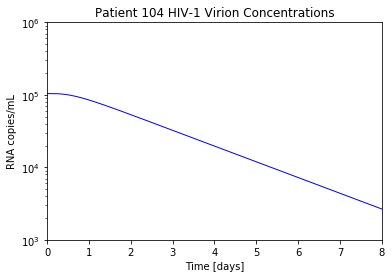

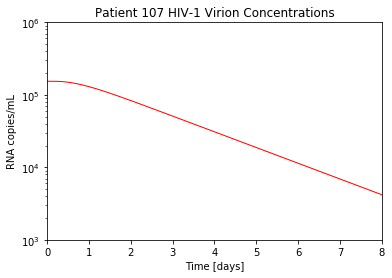

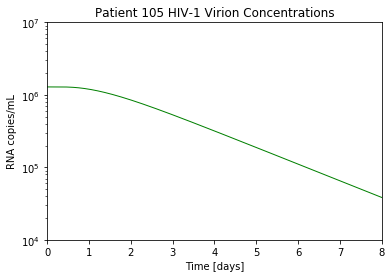

In [3]:
num_t_steps = 300

Patient = np.array([102, 103, 104, 105, 107])

def patient_data(patient_ID):
    
    CD4 = np.array([16, 408, 2, 11, 412])
    Plasma_virions = np.array([294, 12, 52, 643, 77])*10**3
    Delay = np.array([2, 6, 2, 6, 2])
    c_arr = np.array([3.81, 2.73, 3.68, 2.06, 3.09])
    delta_arr = np.array([0.26, 0.68, 0.50, 0.53, 0.50])
    
    for p, ID in enumerate(Patient): # find which index corresponds with patient
        if patient_ID == ID:
            # Get patient-specific values
            Vo = Plasma_virions[p]
            c_val = c_arr[p]
            delta_val = delta_arr[p]
            Days_delay = Delay[p]/24 # get delay in days
            Ttot = CD4[p]
            
            return Vo, c_val, delta_val, Days_delay, Ttot
        
        
def plt_Patient_HIV(x, y, patient_ID, color = 'b', ybounds = (1e3, 1e6), xbounds = (0,8), 
                    OneWindow = False, LnWdth = 1):
        # Plot
        if OneWindow == False:
            plt.figure(figsize = (6,4))
        plt.plot(x, y, color = color, linewidth = LnWdth)
        plt.yscale('log')
        plt.ylim(ybounds)
        plt.xlim(xbounds)
        plt.xlabel('Time [days]')
        plt.ylabel('RNA copies/mL')
        plt.title('Patient %i HIV-1 Virion Concentrations' %patient_ID)
        
        
def RNA_copies_plt(Vary_T = False, patient_ID = 104, color = 'b', ybounds = (1e3, 1e6), pts = num_t_steps, 
                   xbounds = (0,8), OneWindow = False, LnWdth = 1, gnu = 1, c_delta_override = False, 
                   c_override = 3, delta_override = 0.5):
    
        Vo, c_val, delta_val, Days_delay, Ttot = patient_data(patient_ID)

        # Calculate V(t)
        t = np.linspace(0,8, num = pts) 
        RNA_conc = np.zeros(len(t))
        
        if Vary_T == False:
            for i, time in enumerate(t):
                RNA_conc[i] = 2*Fun_Eqn6(Vo, c_val, delta_val, time)
                RNA_conc_wDelay = [2*Vo, 2*Vo] # generate points before drug effect

        else:
            Vi = ODE_Solver(patient_ID, gnu = gnu, c_delta_override = c_delta_override, 
                            c_override = c_override, delta_override = delta_override)[:, 1]
            VNi = ODE_Solver(patient_ID, gnu = gnu, c_delta_override = c_delta_override, 
                             c_override = c_override, delta_override = delta_override)[:, 2]
            RNA_conc = 2*(Vi+VNi)

        # Account for time delay
        t = t + Days_delay # shift t to 'actual' time, accounting for delay
        time_wDelay = [0,Days_delay] # generate points for actual t = 0 to delay time
        time_wDelay.extend(t)
        RNA_conc_wDelay = [2*Vo, 2*Vo] # generate points before drug effect
        RNA_conc_wDelay.extend(RNA_conc)  
        
        # Plot
        plt_Patient_HIV(time_wDelay, RNA_conc_wDelay, patient_ID, color = color, ybounds = ybounds, xbounds = xbounds, OneWindow = OneWindow, LnWdth = LnWdth)
          
            
RNA_copies_plt(patient_ID = 104, color = 'b')
RNA_copies_plt(patient_ID = 107, color = 'r')
RNA_copies_plt(patient_ID = 105, color = 'g', ybounds = (1e4, 1e7));

### (2) Can the model of virion production before treatment show stable or unstable oscillations?

Justify your answer.

I expressed equations 1 and 2 as linear combinations. The Jacobian matrix can be found in the code below, and for each patient, one eigenvalue is positive and the other is negative. This indicates a saddle point, which is an unstable steady state. This will not yield oscillations. Therefore the model of virion production will show neither stable nor unstable oscillations.

In [4]:
for i in range(2): # Run two methods
    for patient_ID in Patient:
        
        Vo, c_val, delta_val, Days_delay, Ttot = patient_data(patient_ID)
        k = 3.43e-8 # viral infectivity rate estimate in ml/(virion *day) from Wein et al. (J. Theor. Biol. 192:81-98)
        T_so = k*Vo*Ttot/(k*Vo+delta_val) # initial concentration of infectious cells
        N = c_val*Vo/(delta_val*T_so)

        # Fill Jacobian
        Jacobian = np.zeros((2,2))
        Jacobian[0,0] = -delta_val
        Jacobian[0,1] = k*(Ttot)
        Jacobian[1,0] = N*delta_val
        Jacobian[1,1] = -c_val
        
        if i == 0: # Method 1: use linalg.eig
            w, v = np.linalg.eig(Jacobian)
            print('Patient %i Eigenvalues:' %patient_ID, w)
            
        # Solved Eigenvalues
        '''else: # Method 2: use solved eigenvalue equations
            Eigen1 = 1/2*(-(c_val+delta_val) + np.sqrt((c_val+delta_val)**2 - 4*(delta_val*c_val - k*(Ttot)*N*delta_val)))
            Eigen2 = 1/2*(-(c_val+delta_val) - np.sqrt((c_val+delta_val)**2 - 4*(delta_val*c_val - k*(Ttot)*N*delta_val)))
            print('Patient %i Eigenvalues from Solved Eigenvalue Equations:' %patient_ID, Eigen1, Eigen2)'''

Patient 102 Eigenvalues: [ 0.00941821 -4.07941821]
Patient 103 Eigenvalues: [ 3.29489571e-04 -3.41032949e+00]
Patient 104 Eigenvalues: [ 1.56966128e-03 -4.18156966e+00]
Patient 105 Eigenvalues: [ 0.01742451 -2.60742451]
Patient 107 Eigenvalues: [ 2.27182112e-03 -3.59227182e+00]


### (3) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [5]:
from scipy.integrate import odeint

# image('Eqn3,4,5.jpg', size = (6, 8))

def ODE_Fun(Y, t, Ttot, delta, c, N, k, gnu):

    T_s, Vi, VNi = Y
    dT_s = k*Vi*(Ttot - T_s) - delta*T_s # eqn 3
    dVi = -c*Vi + (1-gnu)*N*delta*T_s # eqn 4, including effectiveness, which drops out when gnu (effectivity) is 1
    dVNi = gnu*N*delta*T_s - c*VNi # eqn 5, including effectiveness

    return np.array([dT_s, dVi, dVNi])

    
def ODE_Solver(patient_ID, gnu = 1, c_delta_override = False, c_override = 3, delta_override = 0.5):
    Vo, c, delta, Days_delay, Ttot = patient_data(patient_ID)
    
    if c_delta_override == True: # override c and delta with desired values
        c = c_override
        delta = delta_override
        
    k = 3.43e-8 # viral infectivity rate estimate in ml/(virion *day) from Wein et al. (J. Theor. Biol. 192:81-98)

    T_so = k*Vo*Ttot/(k*Vo+delta) # initial concentration of infectious cells
    Vio = Vo # initial infectious virion pool is Vo
    VNio = 0 # initial noninfectious virion pool is 0
    N = c*Vo/(delta*T_so)

    Yo = [T_so, Vio, VNio]
    t = np.linspace(0,8, num = num_t_steps)
    Out = odeint(ODE_Fun, Yo, t, args = (Ttot, delta, c, N, k, gnu))
    return Out

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything but takes in gnu.

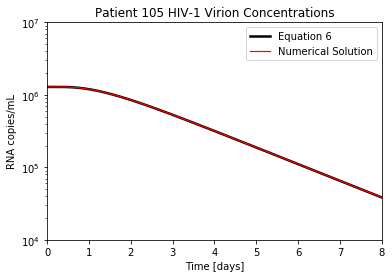

In [6]:
def Compare_ODE2Eq6(patient_ID, ODEcol = 'k', Eq6col = 'b', ODE_LnWdth = 1, 
                    Eq6_LnWdth = 1, ybounds = (1e3, 1e6)):
    ODE = RNA_copies_plt(patient_ID = patient_ID, Vary_T = False, color = Eq6col, ybounds = ybounds, OneWindow = True, LnWdth = Eq6_LnWdth) # Eqn 6
    Eq6 = RNA_copies_plt(patient_ID = patient_ID, Vary_T = True, color = ODEcol, ybounds = ybounds, OneWindow = True, LnWdth = ODE_LnWdth) # ODE
    plt.legend(labels = ('Equation 6', 'Numerical Solution'));
    plt.show()
    
Compare_ODE2Eq6(105, ODEcol = 'r', Eq6col = 'k', ODE_LnWdth = 1.2, Eq6_LnWdth = 2.5, ybounds = (1e4, 1e7))

#### iii. Reproduce the subpanels of Fig. 1 with this updated model. 

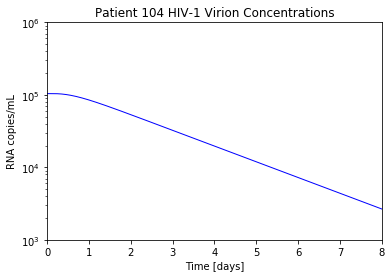

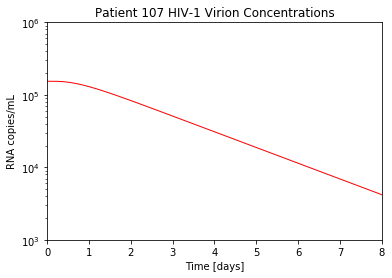

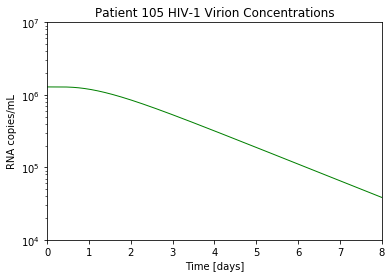

In [7]:
RNA_copies_plt(patient_ID = 104, Vary_T = True, color = 'b', OneWindow = False)
RNA_copies_plt(patient_ID = 107, Vary_T = True, color = 'r', OneWindow = False)
RNA_copies_plt(patient_ID = 105, Vary_T = True, color = 'g', ybounds = (1e4, 1e7), OneWindow = False);

#### iv. Are the results the same as in (1)?

Show evidence of your conclusion.

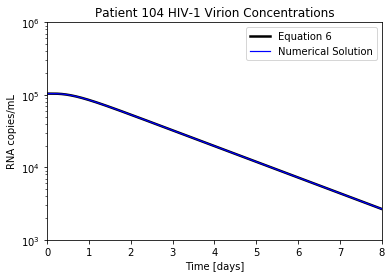

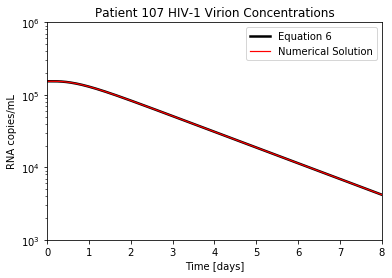

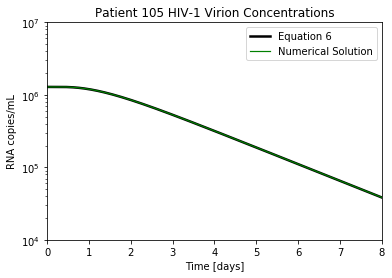

In [8]:
Compare_ODE2Eq6(104, ODEcol = 'b', Eq6col = 'k', ODE_LnWdth = 1.2, Eq6_LnWdth = 2.5)
Compare_ODE2Eq6(107, ODEcol = 'r', Eq6col = 'k', ODE_LnWdth = 1.2, Eq6_LnWdth = 2.5)
Compare_ODE2Eq6(105, ODEcol = 'g', Eq6col = 'k', ODE_LnWdth = 1.2, Eq6_LnWdth = 2.5, ybounds = (1e4, 1e7))

My results with the ODE solver are the same as from equation 6, indicating that their constant-T approximation to develop equation 6 is a good one.

### (3) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days$^{-1}$ and δ=0.5 days$^{-1}$ as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

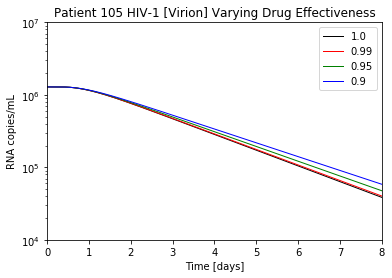

In [9]:
gnu_arr = [1.0, 0.99, 0.95, 0.9]

col = ['k', 'r', 'g', 'b', 'y', 'm']
for i, gnu_i in enumerate(gnu_arr):
    RNA_copies_plt(patient_ID = 105, Vary_T = True, color = col[i], ybounds = (1e4, 1e7), 
                   OneWindow = True, gnu = gnu_i, c_delta_override = True, c_override = 3, delta_override = 0.5)
plt.legend(labels = gnu_arr);
plt.title('Patient 105 HIV-1 [Virion] Varying Drug Effectiveness');

As the effectiveness of ritonavir decreases, the predicted virion concentration increases. This makes sense as the drug is less able to combat the virions.

#### (ii) Then, use the function `scipy.optimize.leastsq` to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [10]:
from scipy.optimize import least_squares

def Diff_Fun(X, patient_ID, gnu):
    
    # Fit RNA_concentration based on 
    Vi_fit = ODE_Solver(patient_ID, gnu = gnu, c_delta_override = True, c_override = X[0], 
                        delta_override = X[1])[:, 1]
    VNi_fit = ODE_Solver(patient_ID, gnu = gnu, c_delta_override = True, c_override = X[0], 
                        delta_override = X[1])[:, 2]
    RNA_conc_fit = 2*(Vi_fit+VNi_fit)
    
    Vi_actual = ODE_Solver(patient_ID, gnu = 1, delta_override = False)[:, 1]
    VNi_actual = ODE_Solver(patient_ID, gnu = 1, delta_override = False)[:, 2]
    RNA_conc_actual = 2*(Vi_actual+VNi_actual)
    
    Diff = RNA_conc_actual - RNA_conc_fit
    
    return Diff

def Fun_Least_Squares(patient_ID, gnu, c_i, delta_i):
    InitialGuess = [c_i, delta_i]
    minBound = [0, 0] # default minimum bound
    maxBound = [np.inf, np.inf] # default maximum bound

    # Run least squares  
    Res = least_squares(Diff_Fun, InitialGuess, bounds=(minBound, maxBound), args=(patient_ID, gnu))
    return Res.x

print('Least Squares Estimates of c and delta')
for i, gnu_i in enumerate(gnu_arr):

    [c, delta] = Fun_Least_Squares(105, gnu_i, c_i = 3, delta_i = 0.5)
    print('   Gnu = %.2f' %gnu_i, ' c = %f' %c, ' delta = %f' %delta)
print('\n"Actual" values for patient 105\n   c = 2.06   delta = 0.53')

Least Squares Estimates of c and delta
   Gnu = 1.00  c = 2.060000  delta = 0.530000
   Gnu = 0.99  c = 2.055708  delta = 0.537470
   Gnu = 0.95  c = 2.037556  delta = 0.569653
   Gnu = 0.90  c = 2.012300  delta = 0.615978

"Actual" values for patient 105
   c = 2.06   delta = 0.53


c is the rate constant for clearange time. As the drug becomes less effective (gnu decreases), the clearance rate decreases. Thus, if we assume that there is 100% effectiveness, we are overestimating the clearance rate. Virions will actually stay around longer than we predict. delta, the rate of loss of virus producing cells, increases as the efficiency decreases. The paper had opposite trends, with c slightly increasing and delta decereasing. I am not sure what could be causing this discrepancy.

#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

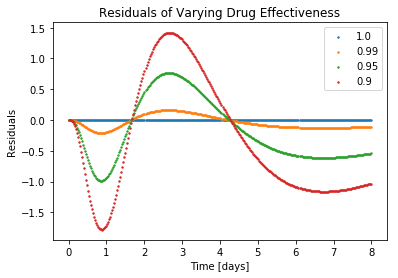

In [11]:
for i, gnu_i in enumerate(gnu_arr):
    InitialGuess = [3, 0.5]
    minBound = [0, 0] # default minimum bound
    maxBound = [np.inf, np.inf] # default maximum bound
    Res = least_squares(Diff_Fun, InitialGuess, bounds=(minBound, maxBound), args=(patient_ID, gnu_i))
    
    t = np.linspace(0,8, num = num_t_steps)
    plt.scatter(t, Res.fun, s = 2)
plt.legend(labels = gnu_arr);
plt.xlabel('Time [days]')
plt.ylabel('Residuals')
plt.title('Residuals of Varying Drug Effectiveness')
plt.show()

As the effectiveness of ritonavir decreases, the residuals become larger negative or positive values. It seems that the model underpredicts virions before day 2, overpredicts between days 2 and 4, and underpredicts after day 4.

### (4) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of $V_I(t=0)$ to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, $V_I$, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

Conversion factor = 0.001866


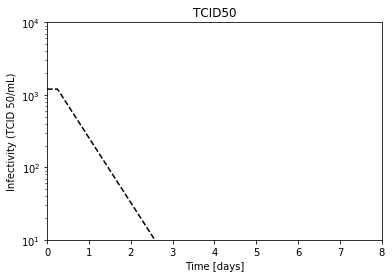

In [12]:
patient_ID = 105
Vo, c, delta_val, Days_delay, Ttot = patient_data(patient_ID)

TCID = 1.2*10**3 # from visual inspection of figure 1B lower panel
Conversion = TCID/Vo #Vo = Vio
print('Conversion factor = %f' %Conversion)

# Convert to TCID
Vi = ODE_Solver(patient_ID)[:, 1]
TCID_50 = Vi * Conversion
    
t = np.linspace(0,8, num = num_t_steps) 
t = t + Days_delay # shift t to 'actual' time, accounting for delay
time_wDelay = [0] # generate points for actual t = 0 to delay time
time_wDelay.extend(t)
TCID_50_wDelay = [TCID] # generate points before drug effect
TCID_50_wDelay.extend(TCID_50)

plt.plot(time_wDelay, TCID_50_wDelay, color = 'k', linestyle = '--')
plt.yscale('log')
plt.ylim(1e1, 1e4)
plt.xlim(0,8)
plt.ylabel('Infectivity (TCID 50/mL)')
plt.xlabel('Time [days]')
plt.title('TCID50');